# Cryosphere model Comparison tool (CmCt) GRACE Mascon Gravimetry Tool

## Mascon dataset description

The CmCt GRACE mascon tool compares user uploaded ice sheet model to GRACE mascon data derived from the GRACE satellite.

The CmCt processes the model to create the same mascon space as the NASA GSFC GRACE mascon product, therefore bringing the ice sheet model and GRACE data to the same spatial resolution for comparison. After the interpolation to the same mascon space has been achieved, the ice sheet model is averaged over within the mascon space to provide a direct qualitative comparison.

For comparison to the user's model, the tool currently uses the `gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd` GRACE mascon product from Apr 2003 to Dec 2023 that can be requested [here](https://earth.gsfc.nasa.gov/geo/data/grace-mascons). This dataset is available upon request. In addition, for plotting coastlines, this tool uses data that can be downloaded from [here](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/)

## Input data requirements

The input ice sheet model should be saved as a netCDF file. There are several requirements for the comparison:

### `Lithk` variable

The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison (should be in units of meters). See Coordinate System and Date Range sections for options on what dimensions this variable should have.

### Coordinate System
%There are three coordinate systems which can be interpretted by the CmCt, indicate which one is appropriate with the "coord_sys" input
%#### Rectangular Polar-Stereographic (rect_pol_st)

Coordinates are defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki/MainPage). This means that in the model netCDF4 file, there are variables x and y such that x has dimensions (x,) and length A and y has dimensions (y,) and length B. In addition, the lithk variable must have dimensions (time, y, x,) and shape (_, A, B).

%#### Polar Stereographic (pol_st)

%Coordinates are defined according to ISMIP6 standard projected polar-stereographic space. The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki/MainPage). This means that in the model netCDF4 file, there is a dimension called "position". There are variables x and y which both have dimensions (position,) and length C. In addition, the lithk variable must have dimensions (time, position,) and shape (_, C,). This differs from rectangular polar stereographic in that the lithk variable does not have to be defined on a rectangle in polar-stereographic space

%#### Latitude Longitude (lat_lon)

%Coordinates are defined according to ISMIP6 standard projected polar-stereographic space. The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki/MainPage). This means that in the model netCDF4 file, there is a dimension called "position". There are variables latitude and longitude which both have dimensions (position,) and length C. In addition, the lithk variable must have dimensions (time, position,) and shape (_, C,)

### Time variable

The model file must include a time variable whose entries are in units of days since 01-01-1970. This variable must have at least two entries. The user will input a start_date and end_date, and the start_date may not be before Apr 2002 (when GRACE data starts) or before the first entry of the time variable of the model file. Likewise, the end_date may not be after Dec 2023 (when GRACE data ends) or after the last entry of the time variable of the model file.

## Using this tool

This tool runs in Jupyter Appmode. The user interface buttons enable upload, plotting, and download.

1. Download the example output, if desired, using the Download Example button.
1. Upload model data for comparison using the Upload File button.
1. Plot GRACE Mascon and Ice Sheet Model Comparison using the Plot Data button.
1. Download the results using the Download Plot button.

The tool first processes the NASA GSFC GRACE product and specifies the mascon space. Then averages over the observational data within the specified mascon space. The CmCt takes the uploaded ice sheet model and converts it to the same mascon space as the observational data. Once the data is in the mascon space it averages over the data within the same space, then plots the comparison side by side.

### Future enhancements

+ A drop-down box will be provided for users to select the start and end date range for the comparison. 
 
+ Data from the GRACE-FO (GRACE Follow-On) mission will be added, to support the full time range from 2003 to 2021. 

## Tool Output

The CmCt creates the GRACE mascon plot and the model mascon plot so the user can  qualitatively compare the model output with the observational data. The plots can be easily downloaded with the Download Plot tab. 

# Import Modules

In [1]:
# set geospatial python3 kernel to provide needed packages
import os,sys
import glob as glob
import numpy as np
import h5py
import mascons
import xarray as xr
import glob as glob
import time

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))

import ipywidgets as widgets
from IPython.display import display,clear_output,HTML
import PIL.Image # Python Image Library

# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

# Enter Inputs

In [2]:
##### Model data #####
#Data dir and filename in which the model can be found
Datadir =os.path.expanduser('/home/jovyan/CmCt/notebooks/Gravimetry/model_files/')
model_file = "lithk_reduces_by_0.6m_2012_to_2013.nc"

##### Start and End Dates #####
start_date = '2012-01-01' # 'YYYY-MM-DD'
end_date = '2013-01-01' # 'YYYY-MM-DD'

##### Plotting #####
# If true, plots the GRACE Mascon data, model prediction data, and residual in units of centimeters of water equivalent
make_plot = True

# If true and make_plot is true, saves the plot to plot_filename
save_plot = False

# filename for output plot (only used if make_plot=True and save_plot = True)
plot_filename = 'output_files/Mascon_comp.png'

## Set Polar Sterographic Projection definition:

##### Projection can be defined from the loaded model or by setting the definition independent of the model. 
#Since the CmCt uses a standard projection, it is probably best to use the second method.

In [3]:
# Method : Set model projection from standard definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

# Select Parameters and Construct Output File

In [4]:
from CMCT_gaivimetry_select_data_parameters import *


parameters = CMCT_gaivimetry_select_data_parameters()
print(parameters)

{'loginname_widget': 'rbasnet'}


In [5]:
from datetime import datetime

output_dir = os.path.expanduser('/home/jovyan/CmCt/RUNS/')

# Construct run_id using username and current time
date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
date2 = datetime.now().strftime('%Y%m%dT%H%M%S')

run_id = parameters['loginname_widget']+ "_" + date2
# print(run_id)

# Create upload dir path
output_dir_act = output_dir + run_id + "/"
print(output_dir_act)

#Make upload directory
os.mkdir(output_dir_act)

output_nc_filename=output_dir_act+'CMCT_'+run_id+'.01.meansdgrids.nc'
print(output_nc_filename)


/home/jovyan/CmCt/RUNS/rbasnet_20240617T134540/
/home/jovyan/CmCt/RUNS/rbasnet_20240617T134540/CMCT_rbasnet_20240617T134540.01.meansdgrids.nc


## Load GRACE and Model Data:

In [6]:
def loadGsfcMascons():
    t = time.time()
    #Load Mascons data
    inpath_1 =os.path.expanduser('/home/jovyan/CmCt/notebooks/Gravimetry/mascon_files/')

    # Load GSFC mascons
    h5_filename = inpath_1 + 'gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd.h5'

    try:
        gsfc = mascons.load_gsfc_solution(h5_filename, lon_wrap='pm180')
    except:
        print('Error: Failed to load GSFC mascons.')
    print("Loading MASCONS data: " + str(time.time() - t) + " seconds")  #TEMPORARY
    return gsfc

In [7]:
# Load user's uploaded model data
def loadGisModel(nc_filename):
    t = time.time()
    
    # Load GIS model into an Xarray
    try:
        gis_ds = xr.open_dataset(nc_filename, autoclose=True, engine='netcdf4')
    except:
        print('Error: Failed to open model data; unexpected format found. Terminating calculation.')

        
    # check for the lithk variable
    try:
        lithk = gis_ds['lithk']
    except:
        print('Error: lithk variable expected but not found in model. Terminating calculation.')

    print("Loading model data: " + str(time.time() - t) + " seconds")  #TEMPORARY
    return gis_ds

# GRACE Mascon Mean Computation

In [8]:
# Compute mascon means
def computeMasconMeans(gsfc):
    t = time.time()
    
    global lat_centers
    global lon_centers
    global max_lons
    global min_lons
    global min_lats
    global max_lats
    global min_mscns
    global max_mscns
    global diverging_max
    global diverging_min
    global I_

    try:
        cmwe_delta = mascons.calc_mascon_delta_cmwe(gsfc, start_date, end_date)
        if cmwe_delta is None:   # Error already printed in line above
            return None
    except:
        with output_widget:
            print('Error: Failed to calculate mascon delta. Terminating calculation.')
        return None
        
    # Select only GIS mascons
    I_ = gsfc.locations == 1
    cmwe_delta = cmwe_delta[I_]
    lat_centers = gsfc.lat_centers[I_]
    lon_centers = gsfc.lon_centers[I_]
    min_lons = gsfc.min_lons[I_]
    max_lons = gsfc.max_lons[I_]
    min_lats = gsfc.min_lats[I_]
    max_lats = gsfc.max_lats[I_]

    min_mscns = np.min(cmwe_delta)
    max_mscns = np.max(cmwe_delta)

    diverging_max = np.max([np.abs(min_mscns), np.abs(max_mscns)])
    diverging_min = -diverging_max

    print("Computing MASCON Means: " + str(time.time() - t) + " seconds")   #TEMPORARY
    return cmwe_delta

## Ice Sheet Model Mascon Mean Computation 

In [9]:
def transformToGeodetic(gsfc, gis_ds):
    
    # Put model into mascon space:

    # To compare with GRACE mascons, we need to compute lat/lon coordinates 
    # for the grid locations and average them into the GSFC mascon boundaries.

    # First, we must transform from the original polar stereographic projection 
    # into a geodetic lat/lon coordinate system. We plot the result of 
    # this transformation to verify that the transformation was successful.

    # Then, we spatially average the data into mascon space and once more plot our result.

    # TODO: evaluate whether this transform has failed and return appropriate error
    
    t = time.time()
    
    # fetch the lithk variable from the model data structure
    lithk = gis_ds['lithk']    # type: xarray.core.dataarray.DataArray
    
    # Transform projection to lat/lon
    geodetic = ccrs.Geodetic(globe=ccrs.Globe('WGS84'))

    yv, xv = np.meshgrid(gis_ds.y.data, gis_ds.x.data)   # x and y information in polar stereographic

    ll = geodetic.transform_points(src_crs=polar_stereographic, x=xv.flatten(), y=yv.flatten())
    lons = ll[:,0]
    lats = ll[:,1]

    lithk_delta = subtractLithkFromStartToEndDate(lithk, start_date, end_date)
    if lithk_delta is None:
        return None
    
    # Mascon-average lithk from GIS
    lithk_delta[np.isnan(lithk_delta)] = 0
    lithk_mascons = mascons.points_to_mascons(gsfc, I_, lats, lons, lithk_delta)
    
    # Ice thickness (m) to cm water equivalent:
    rho_ice = 934 # kg/m^3
    rho_water = 1000 # kg/m^3
    mscns_trim = lithk_mascons * rho_ice / rho_water * 100

    print("Transforming model data to MASCONS space: " + str(time.time() - t) + " seconds") #TEMPORARY
    return mscns_trim

In [10]:
def subtractLithkFromStartToEndDate(lithk, start_date, end_date):
    
    # Convert time variable (which should be in units of days since 01-01-1970) to np.datetime64 before interpolation
    time64 = np.array(lithk.time.data, "datetime64[D]")

    # Check that start date is not before data is collected
    if (((np.datetime64(start_date) - time64[0]) / np.timedelta64(1, 's')) < 0):
        print("Error: Inputted start_date is before first date of data collection " + str(time64[0]))
        return None

    # Check that end date is not after data is collected
    if (((time64[-1] - np.datetime64(end_date)) / np.timedelta64(1, 's')) < 0):
        print("Error: Inputted end_date is after last date of data collection " + str(time64[-1]))
        return None
    
    # Set time coordinate to this new np.datetime64 array
    lithk64 = lithk.assign_coords({"time" : time64})

    # Interpolate lithk value for start and end dates
    lithk_start = lithk64.interp(time=start_date).data.transpose().flatten()
    lithk_end = lithk64.interp(time=end_date).data.transpose().flatten()

    # Compute estimated change in ice thickness between start and end dates
    lithk_delta = lithk_end - lithk_start
    return lithk_delta

In [11]:
def plotFigure(cmwe_delta, mscns_trim,cmwe_diff, gsfc, I_):
    t = time.time()

    plt.figure(figsize=(24,14)) #, dpi=300)

    # Observed
    ax1 = plt.subplot(131, projection=polar_stereographic)
    ax1.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]
    sc = ax1.scatter(lon_centers, lat_centers, 1, c=cmwe_delta, zorder=0, transform=ccrs.PlateCarree(),
                     cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(cmwe_delta))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax1.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())
    
    c = plt.colorbar(sc, orientation='horizontal', ax=ax1, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax1.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    # download coastline here: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

    # Add coastlines on top
    ax1.coastlines(resolution='10m', zorder=10, linewidth=0.5)    
    # Add gridlines
    ax1.gridlines(zorder=5, linestyle=':', linewidth=0.5)

    ax1.set_title('Observed mass change\n({0} to {1})'.format(start_date, end_date), size=14)

    sc.remove()


    # Modeled
    ax2 = plt.subplot(132, projection=polar_stereographic)
    ax2.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

    sc = ax2.scatter(gsfc.lon_centers[I_], gsfc.lat_centers[I_], 1, c=mscns_trim, zorder=0,
                     transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(mscns_trim))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax2.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax2, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax2.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # Add coastlines on top
    ax2.coastlines(resolution='10m', zorder=10, linewidth=0.5)    
    # Add gridlines
    ax2.gridlines(zorder=5, linestyle=':', linewidth=0.5)

    # add model filename to subplot's title
    #ax2.set_title('Modeled mass change\n({0} to {1}\n{3})'.format(start_date, end_date, file_name[1]), size=14)
    model_filename = str.split(file_name, '/')[1]
    ax2.set_title('Modeled mass change\n({0} to {1})'.format(start_date, end_date), size=14)

    sc.remove()
    
    # add some explanatory information
    plt.suptitle('Grace Mascon Comparison Plots', fontsize=25)
    plt.subplots_adjust(top=0.83)


    # Obeserved-Modeled
    ax3 = plt.subplot(133, projection=polar_stereographic)
    ax3.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

    sc = ax3.scatter(lon_centers, lat_centers, 1, c=cmwe_diff, zorder=0, transform=ccrs.PlateCarree(),
                     cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)    
    
    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(cmwe_diff))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax3.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax3, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax3.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # Add coastlines on top
    ax3.coastlines(resolution='10m', zorder=10, linewidth=0.5)    
    # Add gridlines
    ax3.gridlines(zorder=5, linestyle=':', linewidth=0.5)

    # add model filename to subplot's title
    model_filename = str.split(file_name, '/')[1]
    ax3.set_title('Residual mass change\n({0} to {1})'.format( start_date, end_date), size=14)

    sc.remove()
    
    # add some explanatory information
    plt.suptitle('Grace Mascon Comparison Plots', fontsize=25)
    plt.subplots_adjust(top=1.93)#0.83

    if save_plot:
        t7 = time.time()
        plt.savefig(plot_filename)
        print("Saving figure: " + str(time.time() - t7))

    plt.show()
    print("Total plotting and saving: " + str(time.time() - t) + " seconds")   #TEMPORARY

In [12]:
def write_to_netcdf(cmwe_diff,output_filename):
    # Create a DataArray
    # data_array = xr.DataArray(cmwe_diff, dims=['x'], coords={'x': np.arange(len(cmwe_diff))})
    data_array = xr.DataArray(cmwe_diff, dims=['mascons'], coords={'mascons': np.arange(len(cmwe_diff))})

    # Create a Dataset and add the DataArray under the variable name 'cmwe_diff'
    ds = xr.Dataset({'cmwe_diff': data_array})

    # Write the dataset to a NetCDF file, including it in the 'residue' group
    ds.to_netcdf(output_filename, group='residue', mode='w')

    print(f'Data written to {output_filename}.')

# Plot GRACE Mascon and Ice Sheet Model Comparison

In [13]:
# do the computation:
# def runProcessing(file = None):
def runProcessing(file = None,output_filename=output_nc_filename):    
    output_filename

    update_progress(0, "Starting...              ")
    
    # load mascons 
    gsfc = loadGsfcMascons()
    if gsfc is not None:
        update_progress(0.10, "Loaded GRACE data        ")
    else: 
        return None
    
    # load user's input model
    gis_ds = loadGisModel(file)
    if gis_ds is not None:
        update_progress(0.20, "Loaded Model Data        ")
    else: 
        return None
    
    # compute the mascon means
    cmwe_delta = computeMasconMeans(gsfc)
    if cmwe_delta is not None:
        update_progress(0.30, "Computed GRACE Delta cmwe")
    else:
        return None
    
    # Put model into mascon space
    mscns_trim = transformToGeodetic(gsfc, gis_ds)
    """
    try:
         mscns_trim = transformToGeodetic(gsfc, gis_ds)
    except:
        print('Error: model transform to geodetic failed. Terminating calculation.')
        return None
    """
    if mscns_trim is None:
        print('Error: model transform to geodetic failed. Terminating calculation.')
        return None

    update_progress(0.60, "Computed Model Delta cmwe") 



    # calculate and write results as netcdf file
    try:
        ###########################################################################
        ### new variable cmwe_diff to write to nedcdf file as output
        cmwe_diff=mscns_trim-cmwe_delta    # All three of these variables are only for the greenland ice sheet
    except:
        print('Error: Failed to compute residual') 
        return None
    update_progress(0.80, "Computed Residual        ")

    # Save results to NetCDF
    try:
        write_to_netcdf(cmwe_diff,output_filename)
    except Exception as e:
        print(f'Error: Failed to write NetCDF file. {e}')
        return None

    
    # Plot results
    if make_plot:
        try:
            # plotFigure(cmwe_delta, mscns_trim, gsfc, I_, lithk_mascons_cmwe)
            plotFigure(cmwe_delta, mscns_trim,cmwe_diff, gsfc, I_)
        except:
            print('Error: plotting failed.')
            return None
    
        
    # todo: put in some checks
    print("Success")
    return 'Success'

In [14]:
# update processing progress bar
def update_progress(progress, title):
    bar_length = 20
    block = int(20.0*progress)
    text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)    

Starting...               [--------------------] 0.0%
Loading MASCONS data: 0.2732737064361572 seconds
Loaded GRACE data         [##------------------] 10.0%
Loading model data: 0.49172258377075195 seconds
Loaded Model Data         [####----------------] 20.0%
Computing MASCON Means: 0.0012841224670410156 seconds
Computed GRACE Delta cmwe [######--------------] 30.0%
i: 0
Shape of m_lats including NaN: (2,)
Shape of m_lats excluding NaN: (2,)
Model change in meters: -0.6000000238418579

i: 1
Shape of m_lats including NaN: (2,)
Shape of m_lats excluding NaN: (2,)
Model change in meters: -0.6000000238418579

i: 2
Shape of m_lats including NaN: (2,)
Shape of m_lats excluding NaN: (2,)
Model change in meters: -0.6000000238418579

i: 3
Shape of m_lats including NaN: (2,)
Shape of m_lats excluding NaN: (2,)
Model change in meters: -0.6000000238418579

i: 4
Shape of m_lats including NaN: (1,)
Shape of m_lats excluding NaN: (1,)
Model change in meters: -0.6000000238418579

i: 5
Shape of m_lats

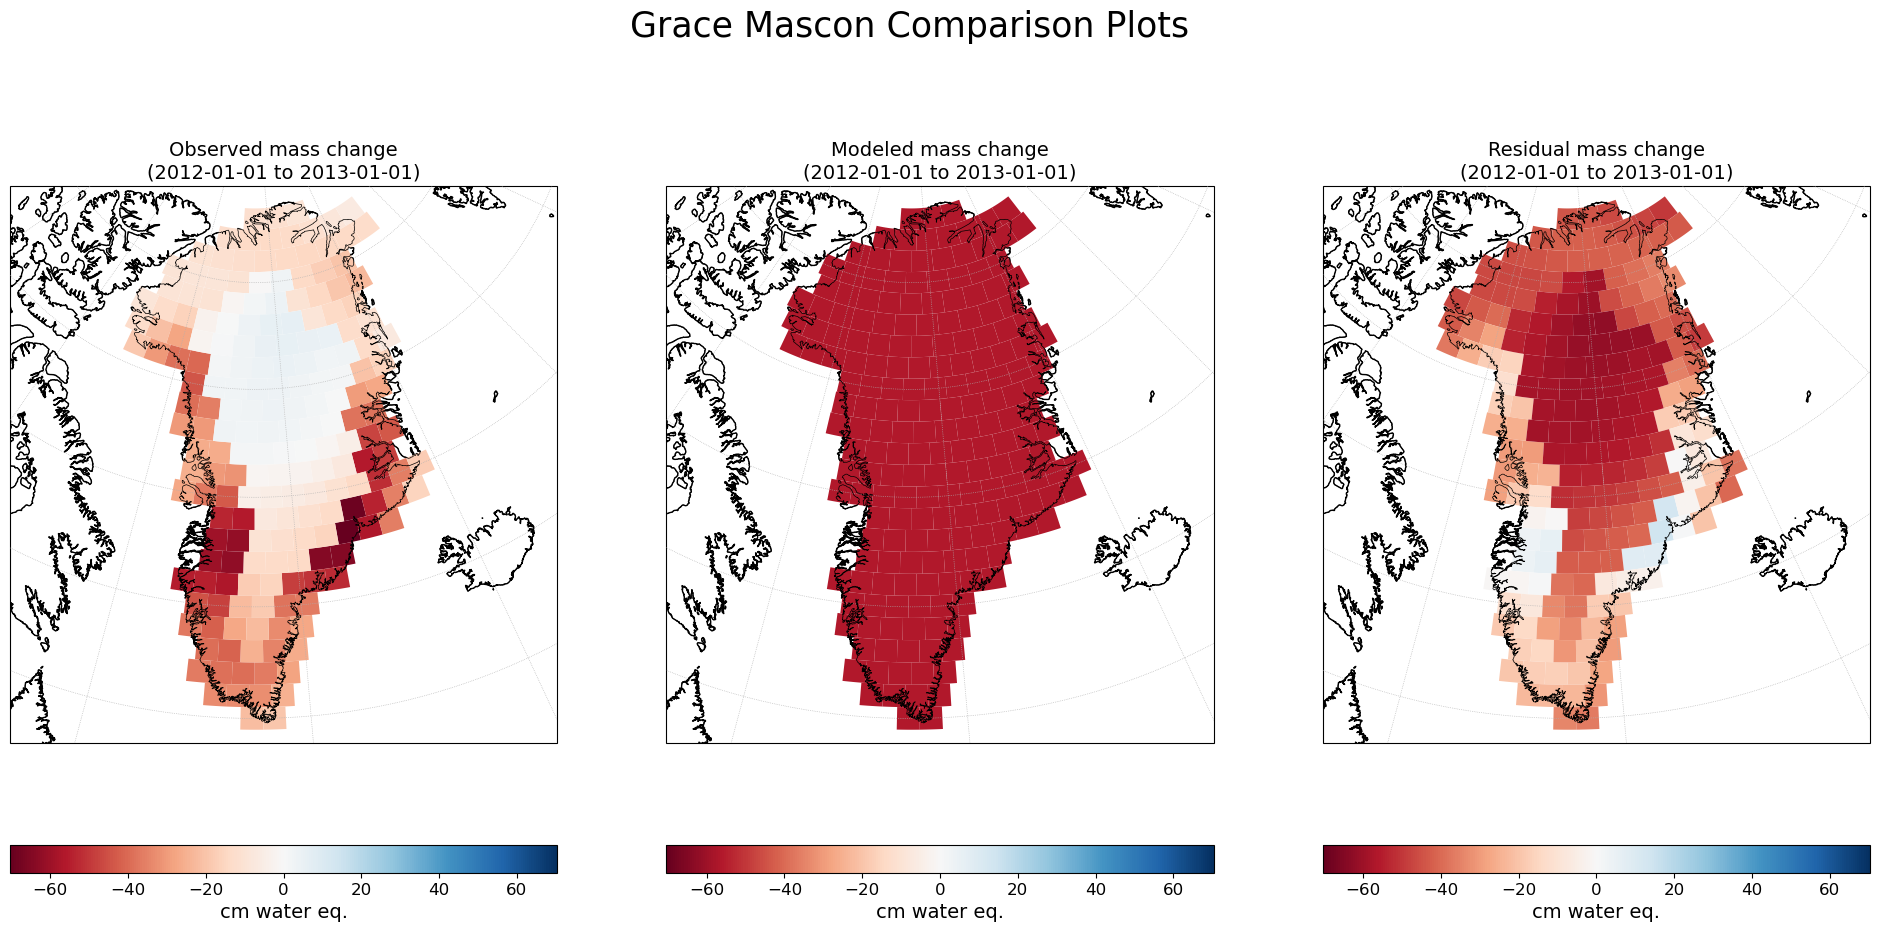

Total plotting and saving: 29.010125875473022 seconds
Success
Total time: 30.12052035331726 seconds


In [15]:

# Process
t_tot = time.time()
file_name=Datadir+model_file
runProcessing(file_name, output_filename=output_nc_filename)
print("Total time: " + str(time.time() - t_tot) + " seconds")